In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
labels = []
with open('./car.label', 'r') as r:
    labels = r.read().strip().split('\n')
labels = [label.split(':')[0] for label in labels]
labels

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [5]:
df = pd.read_csv('car.data', names=labels)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [6]:
df.columns
df.values

array([['vhigh', 'vhigh', '2', ..., 'small', 'low', 'unacc'],
       ['vhigh', 'vhigh', '2', ..., 'small', 'med', 'unacc'],
       ['vhigh', 'vhigh', '2', ..., 'small', 'high', 'unacc'],
       ...,
       ['low', 'low', '5more', ..., 'big', 'low', 'unacc'],
       ['low', 'low', '5more', ..., 'big', 'med', 'good'],
       ['low', 'low', '5more', ..., 'big', 'high', 'vgood']], dtype=object)

In [7]:
df_categorical = df.apply(lambda x: pd.Categorical(x).codes)
df_categorical

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2
...,...,...,...,...,...,...,...
1723,1,1,3,2,1,2,1
1724,1,1,3,2,1,0,3
1725,1,1,3,2,0,1,2
1726,1,1,3,2,0,2,1


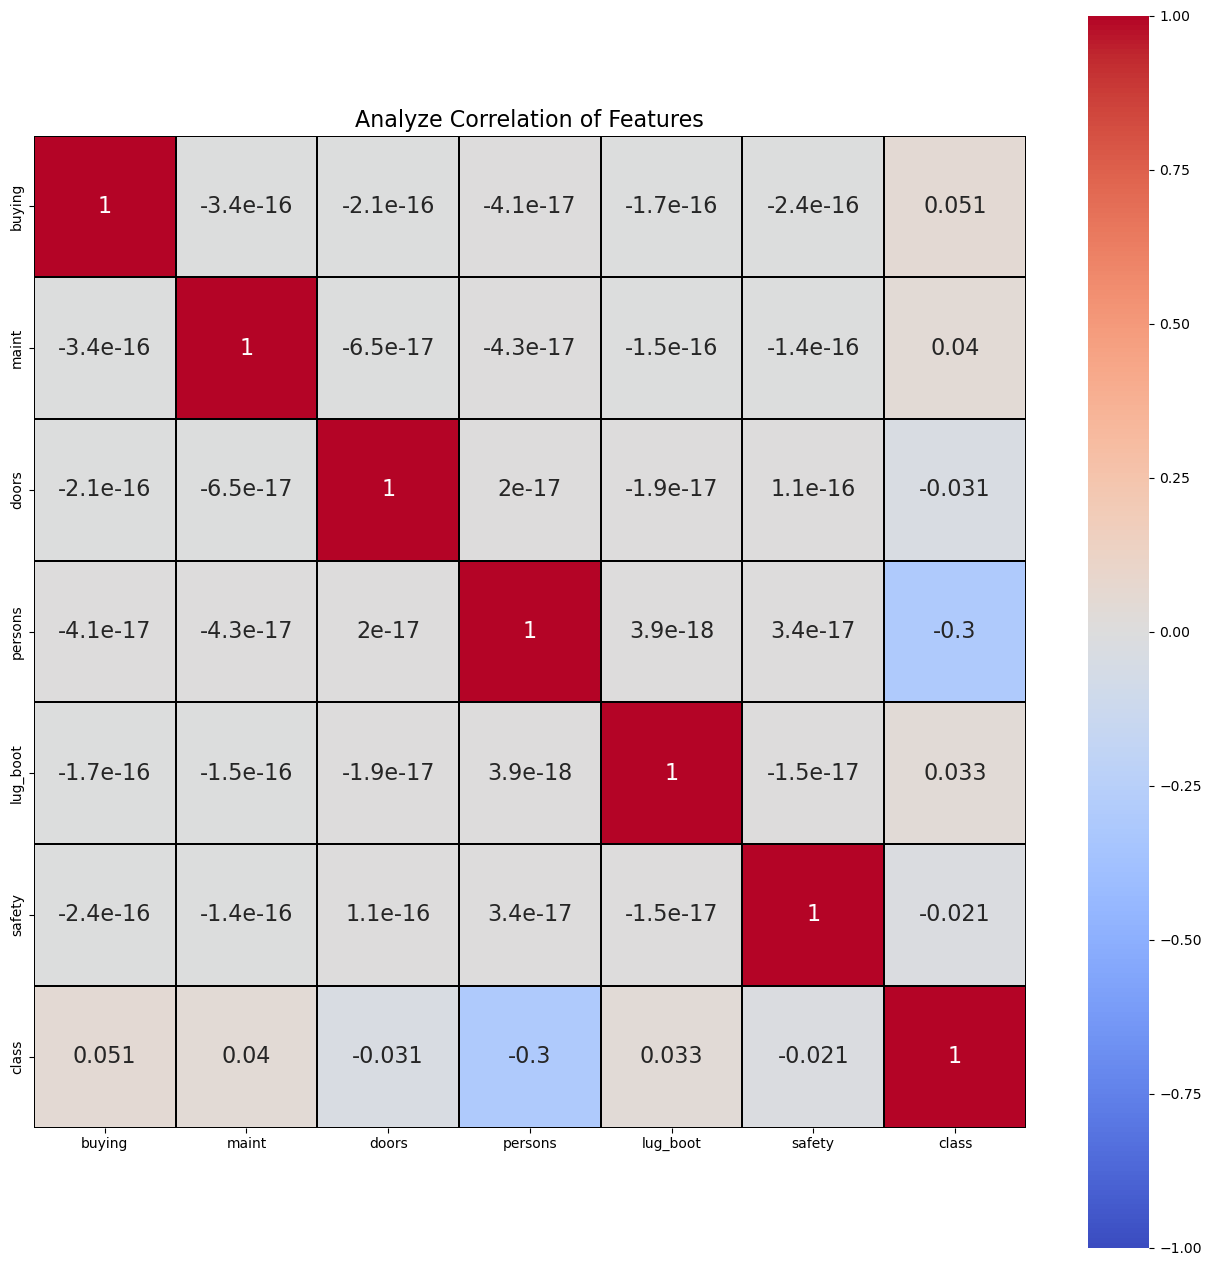

In [8]:
colormap = plt.cm.coolwarm
plt.figure(figsize=(16, 16))
plt.title("Analyze Correlation of Features", y = 1.0, size = 16)
sns.heatmap(df_categorical.astype(float).corr(), linewidths = 0.1, vmin=-1.0, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "black", annot = True, annot_kws = {"size" : 16})
plt.show()

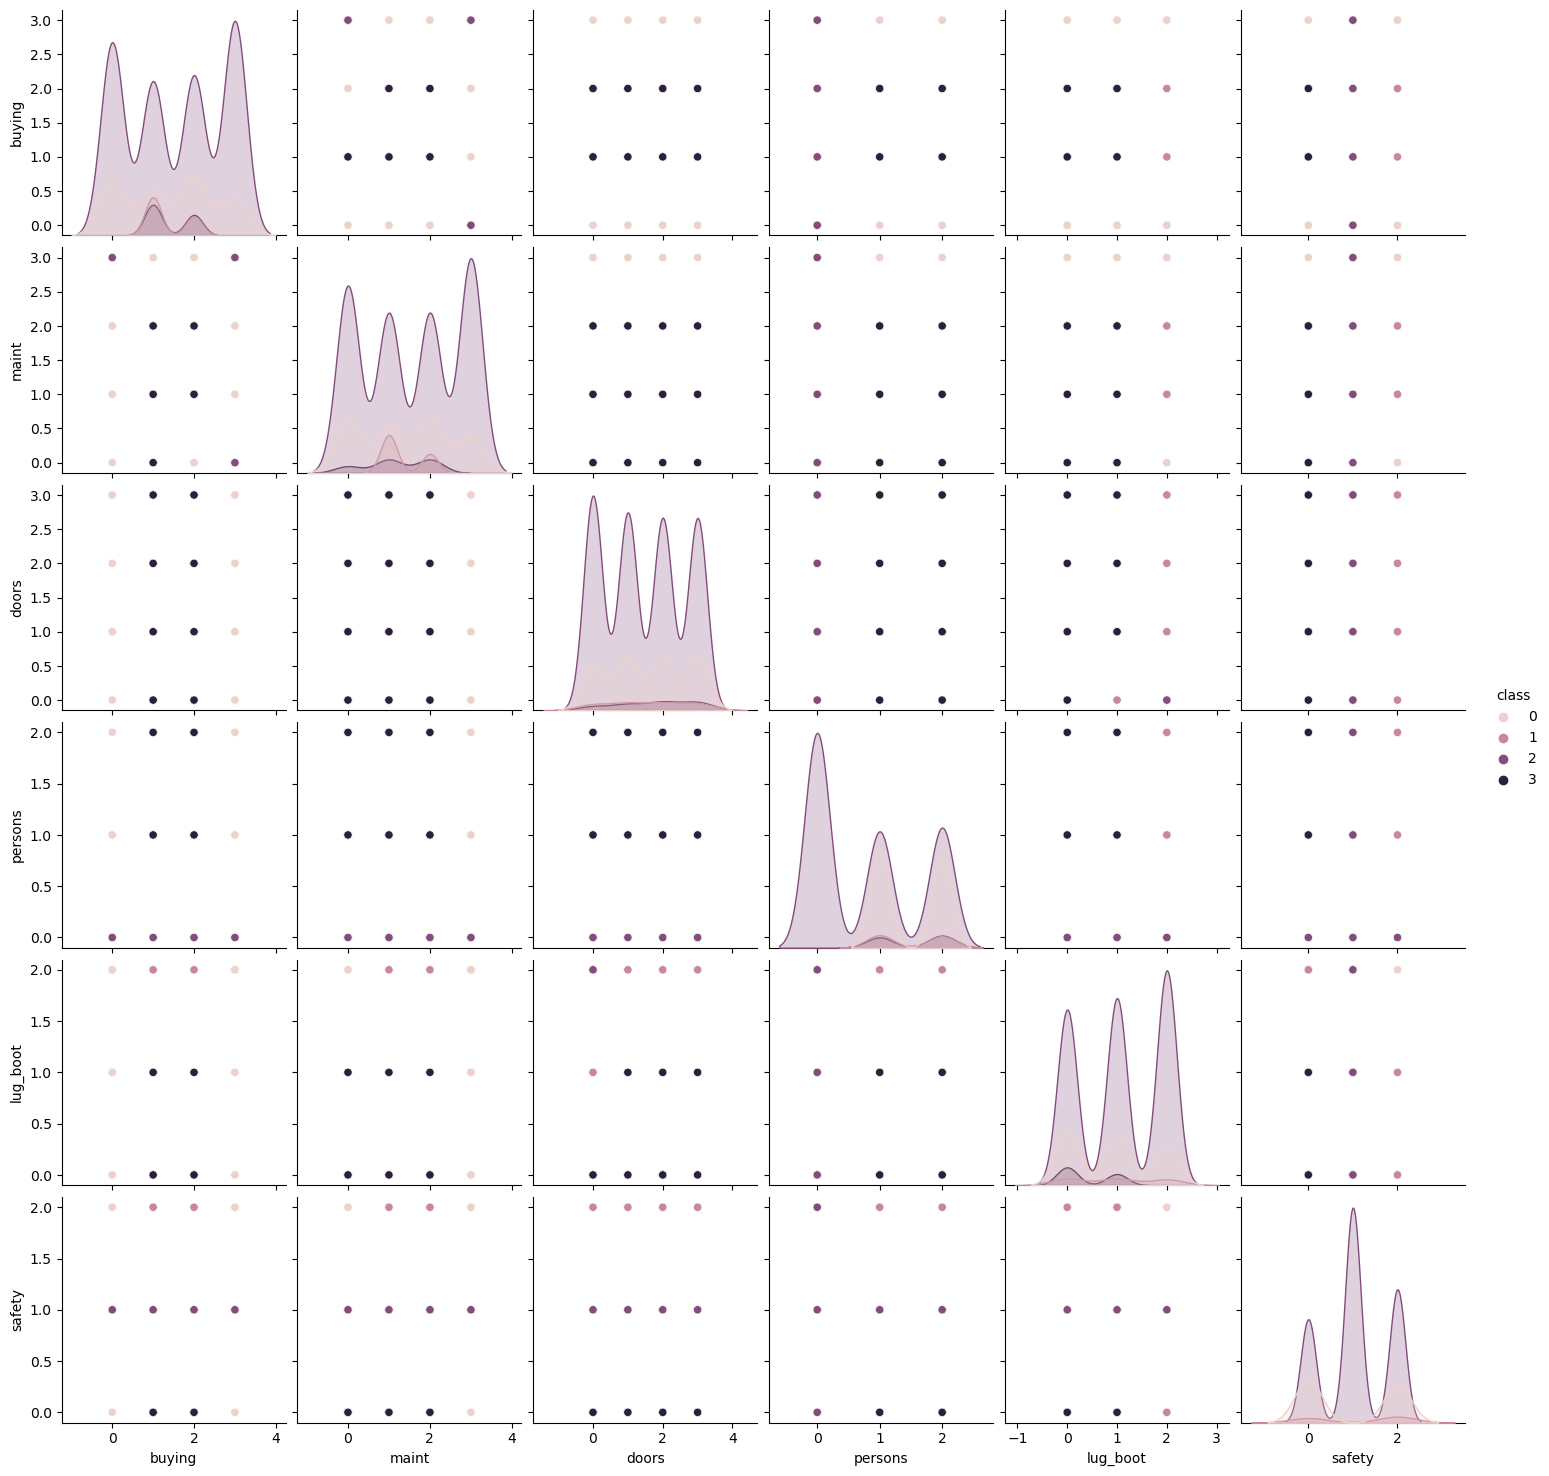

In [9]:
sns.pairplot(df_categorical,
             vars=df_categorical.drop(['class'], axis=1),
            hue ='class')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
x = df_categorical.drop(['class'], axis=1)
y = to_categorical(df_categorical['class'])

x_train, x_test, y_train, y_test = train_test_split(x.values, y, test_size=0.25, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1296, 6), (432, 6), (1296, 4), (432, 4))

In [11]:
from tensorflow import keras as ke

In [21]:
model = ke.Sequential()
model.add(ke.layers.Input(x.shape[1]))
model.add(ke.layers.Dense(64, ke.activations.selu))
model.add(ke.layers.Dense(64, ke.activations.relu))
model.add(ke.layers.Dropout(0.2))
model.add(ke.layers.Dense(64, ke.activations.relu))
model.add(ke.layers.Dense(32, ke.activations.relu))
model.add(ke.layers.Dropout(0.2))
model.add(ke.layers.Dense(64, ke.activations.relu))
model.add(ke.layers.Dense(32, ke.activations.relu))
model.add(ke.layers.Dropout(0.2))
model.add(ke.layers.Dense(y.shape[1], ke.activations.softmax))
model.compile(ke.optimizers.legacy.Adam(learning_rate=5e-6), loss=ke.losses.CategoricalCrossentropy(), metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                448       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 64)               

In [22]:
from tqdm.keras import TqdmCallback
history = model.fit(x_train, y_train, epochs=50, validation_data=(
    x_test, y_test), verbose=0, callbacks=[TqdmCallback(verbose=1)])


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-09-15 10:29:41.968265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-15 10:29:43.369270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


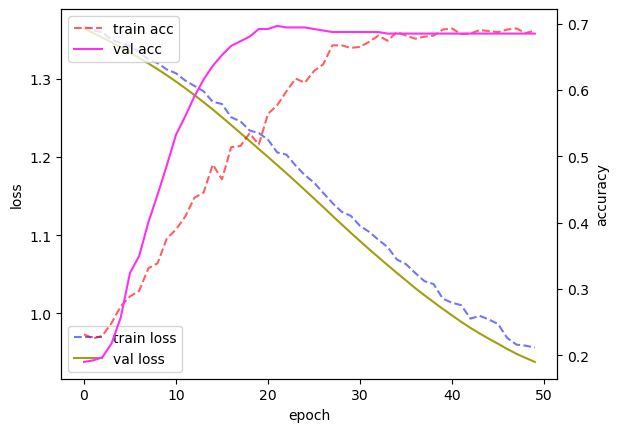

In [23]:
def history_to_graph(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], '#2222ffa0', label='train loss', linestyle='dashed')
    loss_ax.plot(hist.history['val_loss'], '#a0a00f', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='lower left')

    acc_ax.plot(hist.history['accuracy'], '#ff0000a0', label='train acc', linestyle='dashed')
    acc_ax.plot(hist.history['val_accuracy'], '#ff2ff0', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()
history_to_graph(history)